# Тема 8. Доверительное оценивание

In [1]:
import numpy as np
import pandas as pd
import math as mt
import scipy.stats as st
import scipy.optimize as opt
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from collections import namedtuple
from tqdm import tqdm

### 1 Задание

In [2]:
alpha = 0.1
x = np.linspace(0, alpha, 100)

def plot_qdiff(rv, name=None):
    plt.xlabel(r"$\beta$");
    plt.ylabel(r"$y_{1 - \alpha + \beta} - y_{\beta}$");
    y = rv.ppf(1 - alpha + x) - rv.ppf(x)
    plt.plot(x, y, label=name)
    if name is not None: plt.legend()

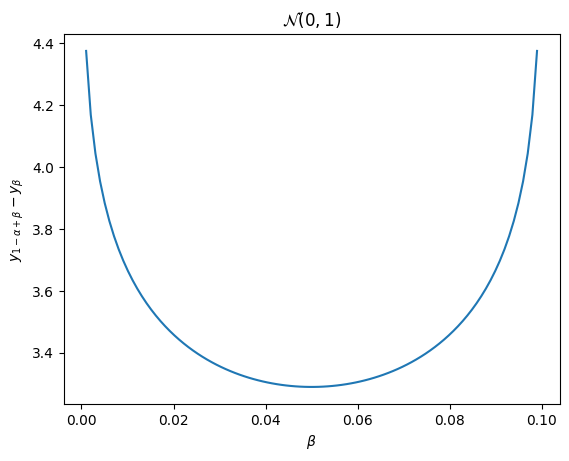

In [3]:
plot_qdiff(st.norm()) 
plt.title(r"$\mathcal{N}(0, 1)$");

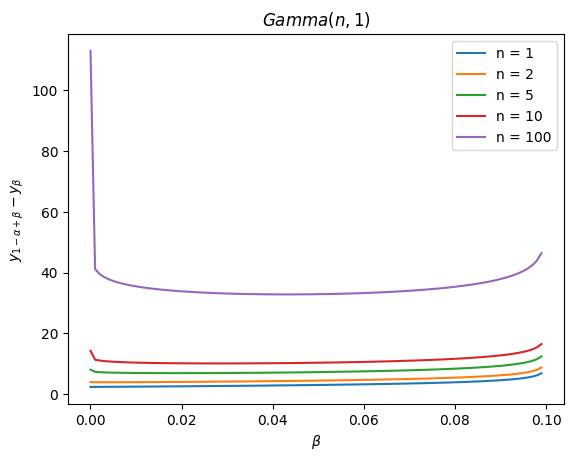

In [4]:
for n in (1, 2, 5, 10, 100):
    plot_qdiff(st.gamma(n, 1), f"n = {n}")
plt.title(r"$Gamma(n, 1)$");

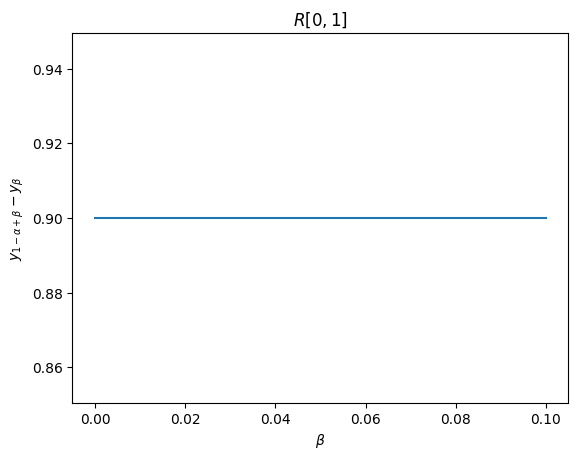

In [5]:
plot_qdiff(st.uniform(0, 1)) 
plt.title(r"$R[0, 1]$");

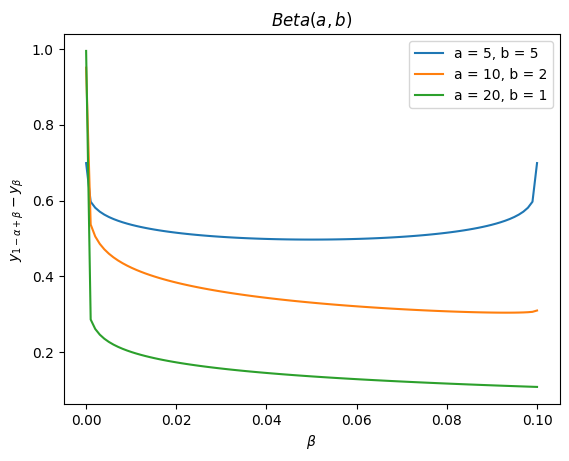

In [6]:
for a, b in ((5, 5), (10, 2), (20, 1)):
    plot_qdiff(st.beta(a, b), f"a = {a}, b = {b}") 
plt.title(r"$Beta(a, b)$");

### 2 Задание

In [13]:
alpha = 0.05
z1, z2 = st.norm.ppf((alpha/2, 1 - alpha/2))
Ns = (20, 50, 100, 200)
k = 1000
theta = 3

def accuracy(left, right):
    n = left.size
    result = np.logical_and(left < theta, theta < right)
    return np.sum(result) / n

df = pd.DataFrame(index=Ns, columns=["Asympt acc", "Exact acc", "Asympt len", "Exact len"])
df.index.name = "n"
for n in Ns:
    samples = st.uniform.rvs(0, theta, size=(k, n))
    
    means = np.mean(samples, axis=1)
    left = 2 * means * (1 + z1 / mt.sqrt(3 * n))
    left = np.maximum(0, left)
    right = 2 * means * (1 + z2 / mt.sqrt(3 * n))
    df.at[n, "Asympt acc"] = accuracy(left, right)
    df.at[n, "Asympt len"] = np.mean(right - left)

    maxims = np.max(samples, axis=1)
    left = maxims / (1 - alpha / 2)**(1 / n)
    left = np.maximum(0, left)
    right = maxims / (alpha / 2)**(1 / n)
    df.at[n, "Exact acc"] = accuracy(left, right)
    df.at[n, "Exact len"] = np.mean(right - left)

    

df

,Asympt acc,Exact acc,Asympt len,Exact len
n,,,,
20,0.929,0.959,1.503252,0.574437
50,0.94,0.958,0.95785,0.223608
100,0.945,0.962,0.678609,0.110845
200,0.94,0.95,0.479918,0.055196


### 3 Задание

In [8]:
alpha = 0.05
z1, z2 = st.norm.ppf((alpha/2, 1 - alpha/2))
Thetas = (0.1, 0.4, 0.5, 0.9)
Ns = (20, 50, 100)
n_thetas, n_Ns = len(Thetas), len(Ns) 
k = 1000

df = pd.DataFrame(index=range(n_thetas * n_Ns), columns=["n", "theta", "Consistent estimator", "Delta Method"])

for i, theta in enumerate(Thetas):
    for j, n in enumerate(Ns):
        ind = i * n_Ns + j
        samples = st.bernoulli.rvs(p=theta, size=(k, n))
        means = np.mean(samples, axis=1)

        est = np.sqrt(means * (1 - means)) 
        lengths = (z2 - z1) * est / mt.sqrt(n) 
        len_mean_est = np.mean(lengths)

        left = np.arcsin(np.sqrt(means)) - z2 / (2 * mt.sqrt(n))
        right = np.arcsin(np.sqrt(means)) - z1 / (2 * mt.sqrt(n))
        lengths = np.sin(right) ** 2 - np.sin(np.maximum(0, left)) ** 2
        len_mean_delta = np.mean(lengths)

        df.iloc[ind] = [n, theta, len_mean_est, len_mean_delta]
df

,n,theta,Consistent estimator,Delta Method
0,20,0.1,0.233776,0.232082
1,50,0.1,0.160597,0.158643
2,100,0.1,0.115498,0.11476
3,20,0.4,0.417157,0.40393
4,50,0.4,0.268983,0.265552
5,100,0.4,0.190931,0.18971
6,20,0.5,0.426887,0.413352
7,50,0.5,0.27434,0.27084
8,100,0.5,0.194964,0.193718
9,20,0.9,0.231514,0.224174
